In [1]:
from efficientnet_pytorch import EfficientNet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b5')

In [5]:
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

456

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b5


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
np.random.seed(42)


In [10]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [11]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [12]:
bs=8

In [13]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

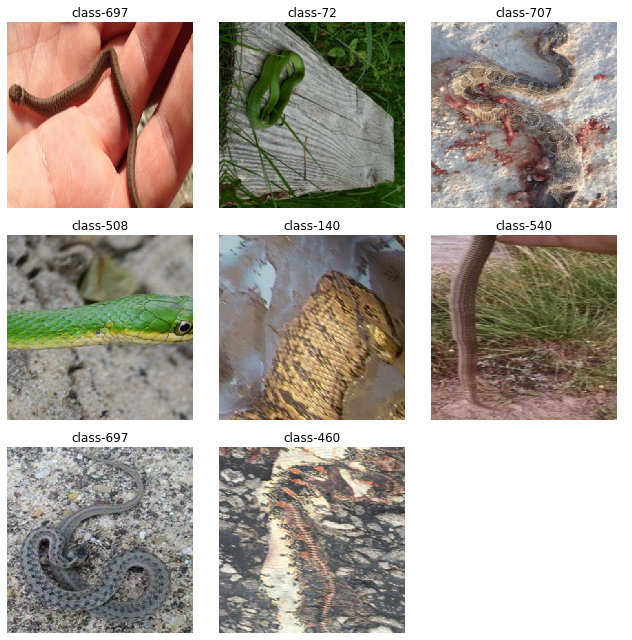

In [14]:
data.show_batch(3,figsize=(9,9))

In [15]:
list(children(model))[-2:]


[BatchNorm2d(2048, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [17]:
ef_head = create_head(2048, data.c, concat_pool=False)
ef_head = nn.Sequential(*(list(ef_head.children())[3:]))

In [18]:
model.add_module('_fc',nn.Linear(2048, data.c))
# model.add_module('_fc',ef_head)

In [19]:
loss_func =LabelSmoothingCrossEntropy()


In [21]:
RMSprop = partial(torch.optim.RMSprop)


In [22]:
from torch.optim import Optimizer

In [23]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')],wd=1e-5)


In [24]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [25]:
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [26]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:19]],
             [learn.model._blocks[19:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [27]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 457, 457]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 230, 230]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 228, 228]       0          False     
_________________________________________________

In [28]:
learn.load('b7-round-2')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [30]:
from fastai.metrics import accuracy, top_k_accuracy

top_2_accuracy = partial(top_k_accuracy, k=2)

In [31]:
learn.metrics=[accuracy,top_2_accuracy]

In [32]:
learn.validate()

[1.2166868, tensor(0.8366), tensor(0.9137)]

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [34]:
learn.metrics = [accuracy,FBeta(beta=1,average='macro'),top_2_accuracy]

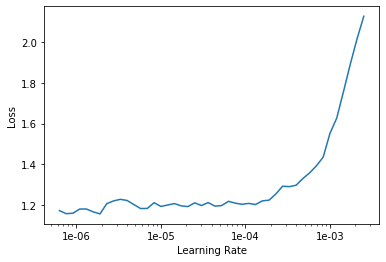

In [35]:
learn.recorder.plot()

In [ ]:
learn.lr_find()

In [36]:
lr=5e-6

In [ ]:
learn.fit_one_cycle(4,max_lr=slice(lr/10,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,1.247791,1.210479,0.839653,0.804402,0.913851,48:21
1,1.195216,1.203781,0.840502,0.805663,0.915125,48:25
2,1.188358,1.196878,0.841048,0.807302,0.916399,48:32


In [ ]:
learn.save('b7-round-3')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


In [ ]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75)


In [ ]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=75,normalize=True)


In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Valid)

In [ ]:
preds.shape

In [ ]:
y_true = data.valid_ds.y.items

In [ ]:
y_true

In [ ]:
probs = np.exp(preds) / np.exp(preds).sum(1)[:,None]

In [ ]:
probs_np = probs.numpy()

In [ ]:
y_pred = []

In [ ]:
result = np.where(data.classes == 'class-4')

In [ ]:
result

In [ ]:
len(y_true)

In [ ]:
count=0

In [ ]:
for i in range(0,45):
    print(str(i)+" "+data.classes[i])

In [ ]:
learn=None
learn=gc.collect()

In [ ]:
count=0
y_pred=[]
for i in range(0,len(y_true)):
    temp = probs_np[i,:]
    max_temp =np.argmax(temp)
    if (max_temp == 3):
        if (temp[3]-temp[0])<0.1:
            y_pred.append(0)
        else:
            y_pred.append(3)
    else:
        if (max_temp == 35):
            print(str(temp[35])+" "+str(temp[0]))
            if (temp[35]-temp[0])<0.1:
                y_pred.append(0)
                count+=1
            else:
                y_pred.append(35)
            
        else:
            y_pred.append(max_temp)
    


In [ ]:
count

In [ ]:
len(y_pred),len(y_true)

In [ ]:
import sklearn.metrics


In [ ]:
sklearn.metrics.accuracy_score(y_true,y_pred)

In [ ]:
sklearn.metrics.f1_score(y_true,y_pred,average='macro')

In [ ]:
import numpy
numpy.savetxt("y_probs.csv", probs_np, delimiter=",")

In [ ]:
learn.save('best')

In [41]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [46]:
learn.load('b5-round-4')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [47]:
learn.validate()

[1.1913782, tensor(0.8446), tensor(0.8145), tensor(0.9175)]

In [48]:
preds,_ = learn.TTA(ds_type=DatasetType.Valid)

In [49]:
import sklearn.metrics

In [50]:
probs = np.exp(preds)/np.exp(preds).sum(1)[:,None]

In [51]:
probs_np = probs.numpy()

In [52]:
y_pred = []
for i in range(0,len(data.valid_ds.y.items)):
    temp = np.asarray(probs_np[i,:])
    y_pred.append(np.argmax(temp))

In [53]:
y_true = data.valid_ds.y.items

In [54]:
sklearn.metrics.accuracy_score(y_true,y_pred)

0.852150700721956

In [56]:
sklearn.metrics.f1_score(y_true,y_pred,average='macro')

0.8205265408423993

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


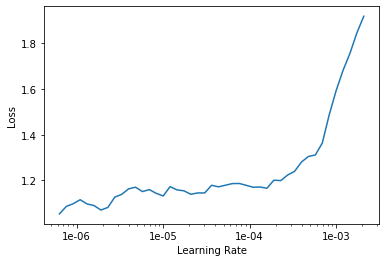

In [60]:
learn.recorder.plot()

In [61]:
lr = 2.5e-6

In [62]:
learn.fit_one_cycle(2,slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,1.215350,1.188822,0.845416,0.812480,0.917673,48:20
1,1.107824,1.191004,0.845416,0.812584,0.917794,48:22


In [63]:
learn.save('b5-round-5')

In [64]:
learn.validate()

[1.1910038, tensor(0.8454), tensor(0.8156), tensor(0.9178)]

In [65]:
lr=1e-7

In [66]:
learn.fit_one_cycle(2,slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,top_k_accuracy,time
0,1.159742,1.189798,0.845780,0.812187,0.918279,48:20


Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fi

KeyboardInterrupt: 

In [1]:
learn.save('b5-round-6')

NameError: name 'learn' is not defined